In [1]:
from workshop_utils import *
import pandas as pd
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Global Edit Counts
This query searches only the changesets table getting basic statistics (for all users)
```sql
SELECT
    changesets.user,
    min(created_at) AS first_edit, 
    max(created_at) AS last_edit, 
    date_diff('day', min(created_at), max(created_at)) AS lifespan,
    sum(num_changes) AS total_edits,
    count(id) AS total_changesets
FROM 
    changesets
GROUP BY 
    changesets.user 
ORDER BY lifespan DESC
```

In [2]:
df = load_dataframe_from_s3('https://us-east-2.console.aws.amazon.com/athena/query/results/6cab4ea3-8431-4cd6-8f89-8881fa43c8b2/csv')

/www/6cab4ea3-8431-4cd6-8f89-8881fa43c8b2.csv
Creating dataframe... done.  Found 1,350,778 rows

In [3]:
df.set_index('user', inplace=True)
df.first_edit = df.first_edit.apply(lambda x: pd.Timestamp(x).date())
df.last_edit = df.last_edit.apply(lambda x: pd.Timestamp(x).date())

In [4]:
df.head(2)

,first_edit,last_edit,lifespan,total_edits,total_changesets
user,,,,,
nickw,2005-04-17,2019-08-16,5233,198756,1771
Steve,2005-04-09,2019-08-07,5232,32634,908


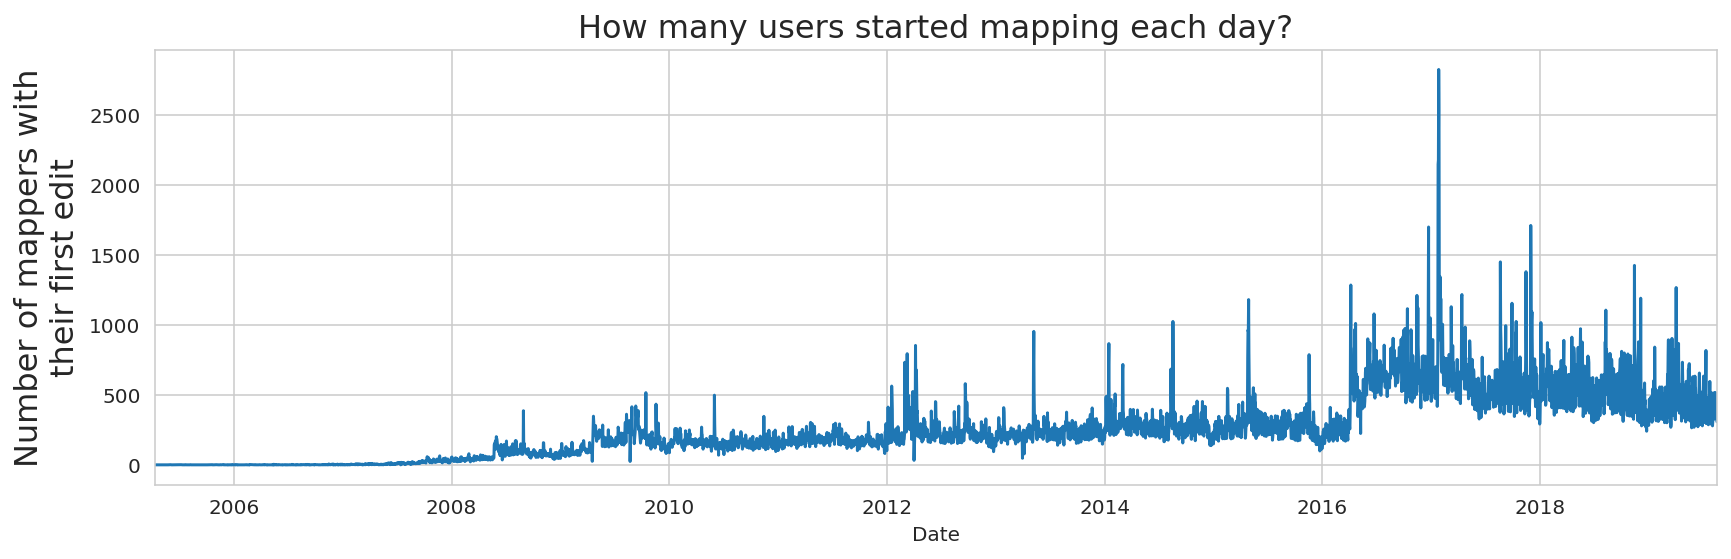

In [5]:
sns.set_style('whitegrid')
ax = df.groupby('first_edit').aggregate('count')['total_edits'].plot(figsize=(14,4))
ax.set_xlabel("Date"); 
ax.set_ylabel("Number of mappers with\ntheir first edit", fontsize=16)
ax.set_title("How many users started mapping each day?", fontsize=16);

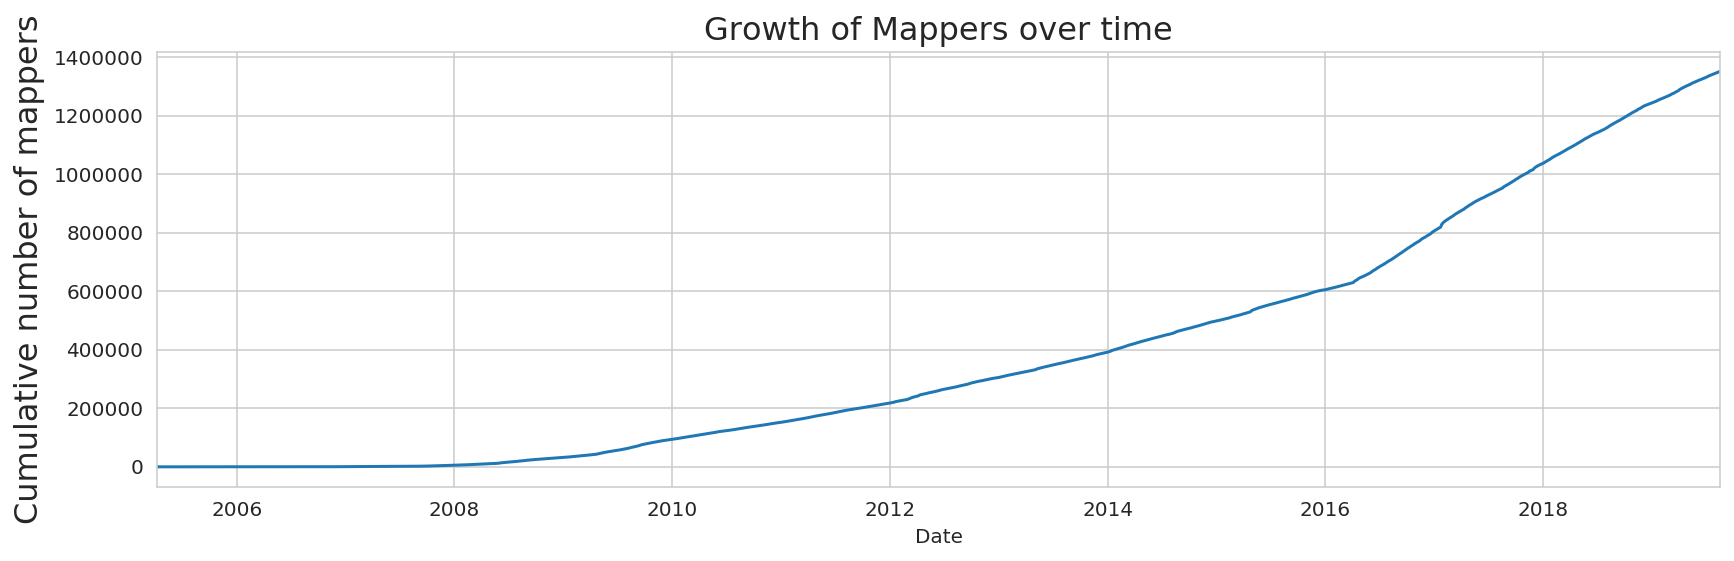

In [6]:
ax = df.groupby('first_edit').aggregate('count')['total_edits'].cumsum().plot(figsize=(14,4))
ax.set_xlabel("Date"); 
ax.set_ylabel("Cumulative number of mappers", fontsize=16)
ax.set_title("Growth of Mappers over time", fontsize=16);

But what is that Spike at 2017?

In [7]:
#Group by date, sort by number of users descending...
df.groupby('first_edit').aggregate('count').sort_values(by='total_edits',ascending=False).head()

,last_edit,lifespan,total_edits,total_changesets
first_edit,,,,
2017-01-26,2822,2822,2822,2822
2017-01-27,2528,2528,2528,2528
2017-01-25,2176,2176,2176,2176
2017-01-24,2146,2146,2146,2146
2017-12-01,1709,1709,1709,1709


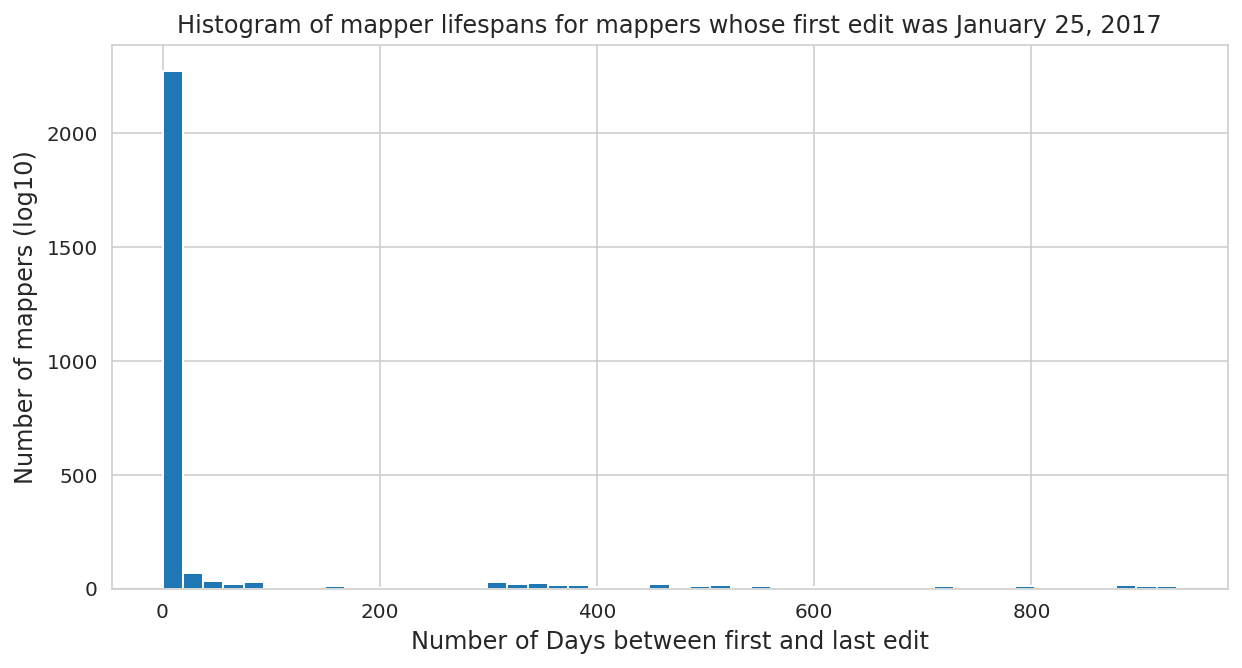

In [8]:
#Let's plot the lifespan for the userse that joined that day?
ax = df[ df.first_edit == pd.Timestamp('2017-01-26').date()][
    'lifespan'].plot(kind='hist',bins=50,figsize=(10,5))
ax.set_xlabel("Number of Days between first and last edit",fontsize=12); ax.set_ylabel("Number of mappers (log10)", fontsize=12)
ax.set_title("Histogram of mapper lifespans for mappers whose first edit was January 25, 2017", fontsize=12);

So, the majority of these users only edited on this one day. Does anyone know what caused this?

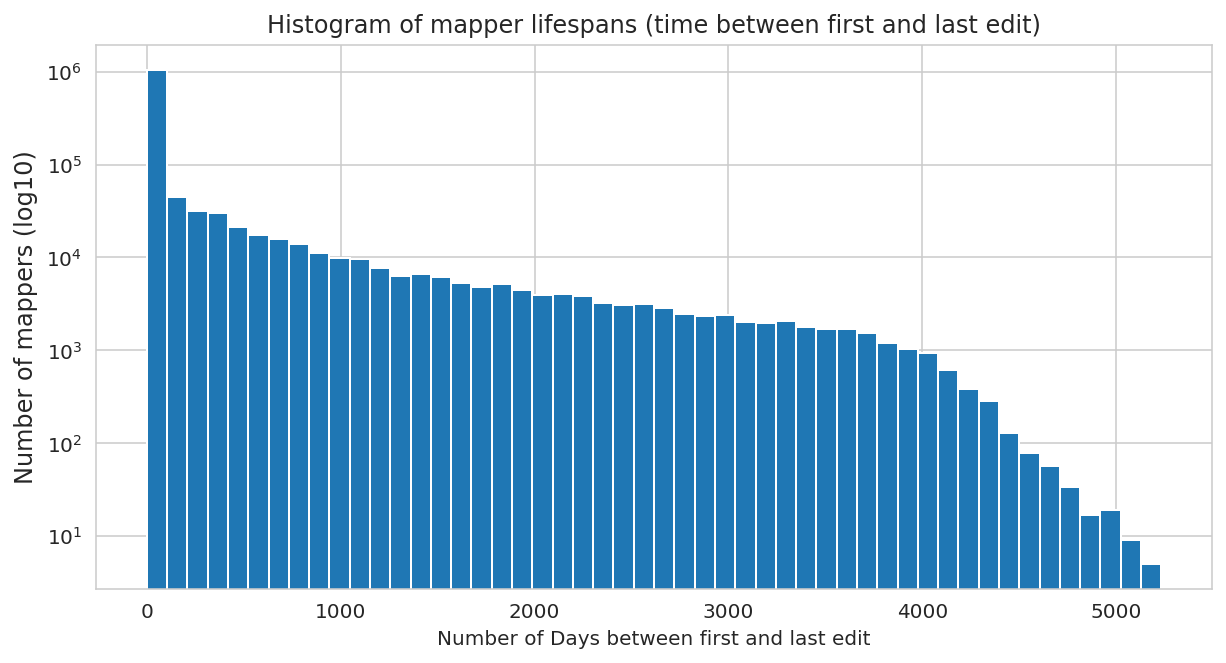

In [9]:
ax = df['lifespan'].plot(kind='hist',bins=50,figsize=(10,5))
ax.set_yscale('log')
ax.set_xlabel("Number of Days between first and last edit"); ax.set_ylabel("Number of mappers (log10)", fontsize=12)
ax.set_title("Histogram of mapper lifespans (time between first and last edit)", fontsize=12);

Pretty standard for online communities...